In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import beta

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.feature_selection import RFECV

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

import shap

In [62]:
def update_beta(swing_col):
    """
    a function that updates the alpha and beta params of the beta
    to give a bayesian estimate of a player's swing perc
    """
    a, b = 5, 5
    expected_swing_pct_list = []
    
    for swing in swing_col:
        expected_swing_pct_list.append(beta(a, b).mean())
        if swing == 1:
            a += 1
        else:
            b += 1
    
    return pd.Series(expected_swing_pct_list, index=swing_col.index)

In [4]:
# excluding columns with data that can only be known after a swing
# has or hasn't occurred
post_swing_cols = ['hc_x', 'hc_y', 'hit_location', 'launch_speed', 'launch_angle', 'babip_value',
                    'iso_value', 'woba_value', 'woba_denom', 'launch_speed_angle', 'post_away_score',
                    'post_home_score', 'post_fld_score', 'post_bat_score', 'delta_run_exp',
                    'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'events',
                    'type', 'delta_home_win_exp', 'bb_type', 'hit_distance_sc', 'description',
                    'des']

# columns with id or redundant info. names excluded rather because 
# than id numbers because there are duplicates. umpire, spin_dir are null
useless_or_null_cols = ['pitch_uid', 'game_pk', 'sv_id', 'pitcher_name', 'batter_name', 'umpire', 
                        'spin_dir', 'pitcher.1', 'fielder_2.1', 'fielder_2', 'fielder_3', 'fielder_4',
                        'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9']

# loading df w/excluded cols to save mem
df = pd.read_csv('train.csv', usecols=lambda x: x not in post_swing_cols and x not in useless_or_null_cols)
df = df.sort_values(by='game_date').reset_index(drop=True)

df.head()

,game_date,pitcher,batter,pitch_type,release_speed,release_pos_x,release_pos_z,zone,game_type,stand,...,pitch_name,home_score,away_score,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,attack_zone,swing
0,2020-07-23,592767,605141,FC,88.8,2.13,6.49,13.0,R,R,...,Cutter,1,1,1,1,Infield shift,Standard,144.0,chase,0
1,2020-07-23,543037,519346,SL,90.4,-1.92,5.59,14.0,R,L,...,Slider,1,2,1,2,Infield shift,Standard,162.0,waste,0
2,2020-07-23,543037,519346,KC,85.3,-1.95,5.64,14.0,R,L,...,Knuckle Curve,1,2,1,2,Infield shift,Standard,48.0,shadow,1
3,2020-07-23,453286,650402,FF,94.2,-3.17,5.38,12.0,R,R,...,4-Seam Fastball,1,3,3,1,Infield shift,Standard,219.0,chase,0
4,2020-07-23,453286,650402,SL,84.0,-3.44,5.20,14.0,R,R,...,Slider,1,3,3,1,Infield shift,Standard,112.0,waste,0


In [9]:
# engineering a few features
# maybe players swing conditional on a lead/deficit etc
df['score_differential'] = df['bat_score'].sub(df['fld_score'])

# maybe total movement matters more than movement in either dimension
df['total_movement'] = np.sqrt(df['pfx_x'] ** 2 + df['pfx_z'] ** 2)

# a larger strike zone seems like it would force more swinging
df['total_strike_zone'] = df['sz_top'].sub(df['sz_bot'])

# month? some proxy for temperature. who knows?
df['game_date'] = pd.to_datetime(df['game_date'])
df['month'] = df['game_date'].dt.month
df['year'] = df['game_date'].dt.year
df['first_day_season'] = df.groupby('year')['game_date'].transform(lambda x: x.min())

# changing the first day of 2020 to March 15th (made up, but in between the others)
df.loc[df['first_day_season'] == pd.to_datetime('2020-07-23'), 'first_day_season'] = pd.to_datetime('2020-03-15')

# days since beginning of season
df['days_since_firstday'] = (df['game_date'] - df['first_day_season']).dt.days

# converting strikes and balls to a 'count' category, might help
df['count'] = df['strikes'].astype(str) + '_' + df['balls'].astype(str)
df['count'] = df['count'].astype('category')

# simple binaries for above/below strike zone
df['above_sztop'] = (df['sz_top'] <= df['plate_z']).astype(int)
df['below_szbot'] = (df['sz_bot'] >= df['plate_z']).astype(int)

# simple binary for 'over plate' when it crosses plate
df['over_plate'] = abs(df['plate_x']) <= 0.83

In [57]:
# unique pitches dict -> how many pitches does each pitcher have?
unique_pitches_dict = df.groupby('pitcher')['pitch_type'].nunique().to_dict()
df['pitcher_unique_pitches'] = df['pitcher'].map(unique_pitches_dict)

# pitch type pitch percentage by pitcher
pitch_type_df = df.groupby('pitcher')['pitch_type'].value_counts(normalize=True).reset_index(name='percentage')
pitch_type_dict = pitch_type_df.set_index(['pitcher', 'pitch_type'])['percentage'].to_dict()
df['pitch_type_perc'] = [pitch_type_dict[(x, y)] for x, y in zip(df['pitcher'], df['pitch_type'])]

In [15]:
# determining pitcher handedness using the release x coordinate
df['pitcher_release_median'] = df.groupby('pitcher')['release_pos_x'].transform(lambda x: x.median())
df['pitcher_distance_from_median'] = df['release_pos_x'].sub(df['pitcher_release_median'])
df['pitcher_handedness'] = np.where(df['pitcher_release_median'] <=0, 1, 0)

In [16]:
# calculating z score of pitch velocity in the y dimension for
# each pitcher and pitch-type
df['pitch_speed_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['vy0']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# calc'ing z score of acceleration in y dimension for
# each pitcher and pitch type
df['pitch_yacceleration_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['ay']
    .transform(lambda x: (x - x.mean()) / x.std())
)

# same calc for z dimension
df['pitch_zacceleration_z_score'] = (
    df
    .groupby(['pitcher', 'pitch_type'])['az']
    .transform(lambda x: (x - x.mean()) / x.std())
)

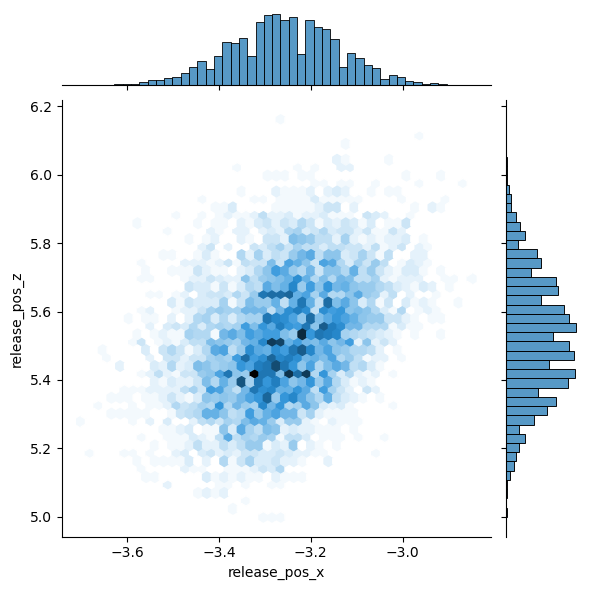

In [12]:
# plotting release x, y joint plot, just inspecting data etc
sns.jointplot(x='release_pos_x', y='release_pos_z', data=df[df['pitcher'] == 453286], kind='hex')

In [17]:
# since the dataset game_dates do not overlap, i'll create some expanding statistics
# for each player. i will fillna as if i know nothing and use only the expanding
# swing percentage to date in the dataset(s)
# i've decided this sucks and if i use it i'll use a beta-binomial.
# note to self: see if it improves model on a .sample() for the data
# also see if it improves model if it is applied to batter-zone groups

df['batter_swing_perc'] = (
    df
    .groupby('batter')['swing']
    .transform(lambda x: x.shift().expanding(min_periods=30).mean())
)

df['pitcher_swing_perc'] = (
    df
    .groupby('pitcher')['swing']
    .transform(lambda x: x.shift().expanding(min_periods=30).mean())
)

pfx_x, pfx_z = horizonal_movement_catcher, vertical_movement_catcher  
plate_x, plate_z = horizontal_position_plate, vertical_position_plate5  
sz_top, sz_bot = strike_zone_top, strike_zone_bottom  
vx0, vy0, vz0 = velocity_in_x, velocity_in_y, velocity_in_z  
ax, ay, az = acceleration_in_x, velocity_in_y, velocity_in_z

In [18]:
# checking the summary stats of a few columns
df[['sz_top', 'sz_bot', 'plate_x', 'plate_z', 'pfx_x', 'pfx_z']].describe().T

,count,mean,std,min,25%,50%,75%,max
sz_top,1443276.0,3.389314,0.173289,2.50,3.30,3.40,3.49,4.47
sz_bot,1443276.0,1.585643,0.098063,0.77,1.53,1.59,1.64,2.29
plate_x,1443276.0,0.042901,0.845338,-8.41,-0.53,0.04,0.61,9.11
plate_z,1443276.0,2.274539,0.979735,-5.07,1.64,2.28,2.92,13.58
pfx_x,1443276.0,-0.117368,0.869179,-2.87,-0.85,-0.19,0.58,2.84
pfx_z,1443276.0,0.643119,0.750901,-2.13,0.18,0.74,1.27,2.80


In [19]:
# figuring out what zones mean
df.groupby('zone').agg({'plate_x' : ['min', 'max'],
                        'plate_z' : ['min', 'max']})

plate_x       plate_z       
         min   max     min    max
zone                             
1.0    -0.83 -0.28    2.07   4.30
2.0    -0.28  0.28    2.14   4.13
3.0     0.28  0.83    2.21   4.15
4.0    -0.83 -0.28    1.61   3.58
5.0    -0.28  0.28    1.60   3.45
6.0     0.28  0.83    1.52   3.34
7.0    -0.83 -0.28    1.13   2.66
8.0    -0.28  0.28    1.07   2.60
9.0     0.28  0.83    1.07   2.66
11.0   -8.41  0.00    1.93  13.58
12.0    0.00  9.11    1.84   8.82
13.0   -5.39  0.00   -5.07   2.98
14.0    0.00  8.83   -4.98   3.09

<Axes: xlabel='game_year,month'>

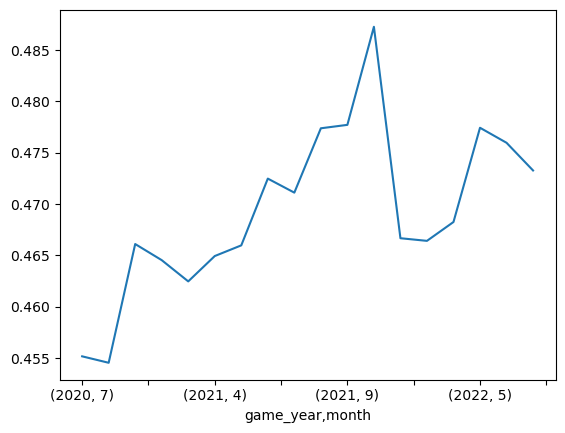

In [16]:
# looking at the swing % over game year and month
# looks like it is increasing - build a linear model
# perhaps
df.groupby(['game_year', 'month'])['swing'].mean().plot()

In [ ]:
df['batter_swing_prob'] = df.groupby('batter', group_keys=False)['swing'].apply(update_beta)

In [ ]:
df['pitcher_swing_prob'] = df.groupby('pitcher')['swing'].apply(update_beta)

<Axes: >

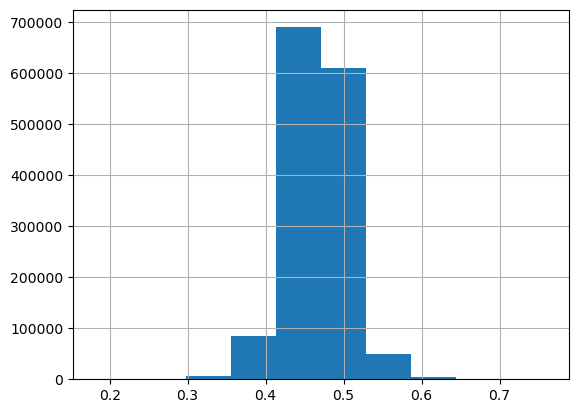

In [82]:
df['pitcher_swing_prob'].hist()

In [83]:
# extracted w/permutation importance
important_features = ['total_strike_zone', 'sz_bot', 'sz_top', 'zone', 'attack_zone',
                      'plate_x', 'count', 'pfx_x', 'pfx_z', 'plate_z', 'game_type', 
                      'over_plate', 'batter_swing_prob', 'pitcher_swing_prob']

In [84]:
eighty_perc = int(np.ceil(0.8 * len(df)))

X = df[important_features].copy()
y = df['swing']

X_train, X_test = X.iloc[:eighty_perc].copy(), X.iloc[eighty_perc:].copy()
y_train, y_test = y.iloc[:eighty_perc].copy(), y.iloc[eighty_perc:].copy()

In [93]:
cat_columns = X_train.select_dtypes(exclude='number').columns
cat_indices = [X_train.columns.get_loc(col) for col in cat_columns]

pipeline = Pipeline([
    ('encoder', OrdinalEncoder(unknown_value=9999999, handle_unknown='use_encoded_value')),
    ('model', HistGradientBoostingClassifier(learning_rate=0.1,
                                             max_depth=6,
                                             min_samples_leaf=4,
                                             categorical_features=cat_indices,
                                             random_state=24))
])

# param_grid = {
#     'model__max_depth': [4, 5, 6],
#     'model__min_samples_leaf': [4, 5, 6]
# }

# gridsearch = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
# gridsearch.fit(X_train, y_train)


pipeline.fit(X_train, y_train)

preds = pipeline.predict_proba(X_test)
print("the log loss on the test set is:", log_loss(y_test, preds[:,1]))

the log loss on the test set is: 0.5727121759201941


In [86]:
# calculating permutation importance using neg log loss on 10% of the dataset
p = permutation_importance(
    pipeline,
    X_test[important_features], y_test,
    n_repeats=5,
    scoring='neg_log_loss',
    max_samples=0.1, 
    random_state=44
)

# converting the permutation importance results to a dataframe
imp_df = (
    pd.DataFrame(
        {'feature' : X_test[important_features].columns,
         'importance_mean' : p['importances_mean'],
         'importance_std' : p['importances_std']})
)

# displaying the df sorted by the mean of importances
imp_df.sort_values(by='importance_mean', ascending=False)

,feature,importance_mean,importance_std
0,total_strike_zone,0.179581,0.003011
1,sz_bot,0.126502,0.002377
6,count,0.107969,0.001596
5,plate_x,0.068152,0.000683
4,attack_zone,0.066548,0.001523
3,zone,0.064967,0.001550
9,plate_z,0.057086,0.001361
7,pfx_x,0.044648,0.000829
8,pfx_z,0.044456,0.000819
2,sz_top,0.036512,0.000886


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


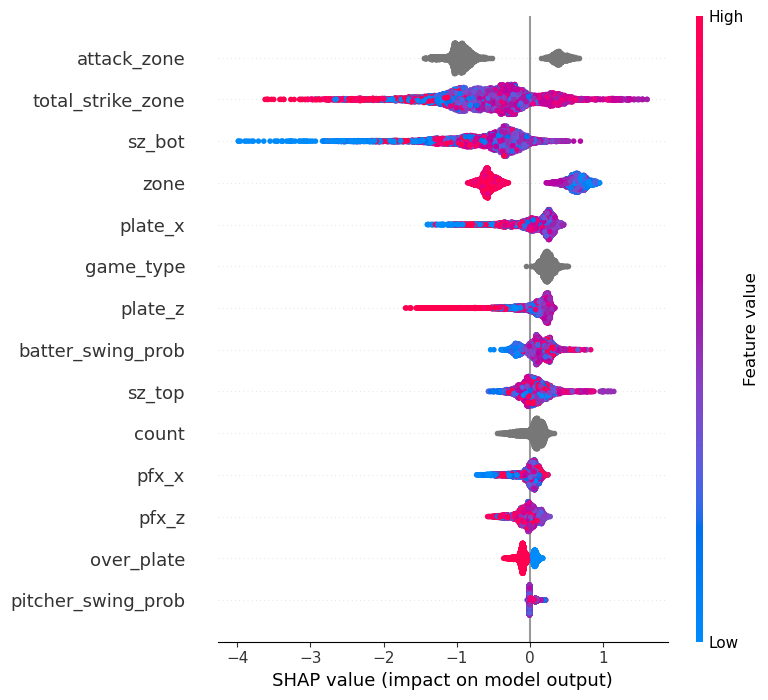

In [87]:
# creating a smaller dataset for the shap explainer
X_test_small = X_test[important_features].sample(8000).copy()

# set the tree explainer as the model of the pipeline
explainer = shap.TreeExplainer(pipeline['model'])

# apply the preprocessing to x_test
observations = pipeline['encoder'].transform(X_test_small)

# get Shap values from preprocessed data
shap_values = explainer.shap_values(observations)

# plot the feature importance
shap.summary_plot(shap_values, X_test_small)

In [94]:
# i'm satisfied with the method, so training the model on the entire dataset

final_model = Pipeline([
    ('encoder', OrdinalEncoder(unknown_value=9999999, handle_unknown='use_encoded_value')),
    ('model', HistGradientBoostingClassifier(learning_rate=0.1,
                                             max_depth=6,
                                             min_samples_leaf=4,
                                             categorical_features=cat_indices,
                                             random_state=24))
])

final_model.fit(X, y)

Pipeline(steps=[('encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=9999999)),
                ('model',
                 HistGradientBoostingClassifier(categorical_features=[4, 6, 10,
                                                                      11],
                                                max_depth=6, min_samples_leaf=4,
                                                random_state=24))])

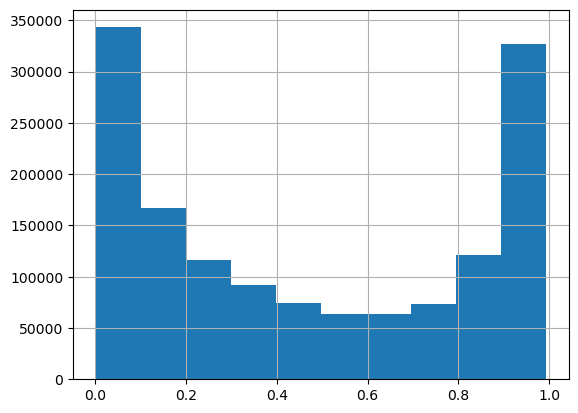

In [115]:
# looking at the predicted probabilities on the original dataset
df_preds = final_model.predict_proba(X[important_features])[:,1]
df['preds'] = df_preds

pd.Series(df_preds).hist()

plt.show()

In [99]:
# getting the beta params for each player - i could update the
# beta params for each row of the test set, but i will not do
# this

batter_swing_dict = df.groupby('batter')['batter_swing_prob'].last().to_dict()
pitcher_swing_dict = df.groupby('pitcher')['pitcher_swing_prob'].last().to_dict()

In [102]:
# loading test dataframe
test_df = pd.read_csv('test.csv')

# creating the features needed for the model
test_df['over_plate'] = abs(test_df['plate_x']) <= 0.83
test_df['count'] = test_df['strikes'].astype(str) + '_' + test_df['balls'].astype(str)
test_df['count'] = test_df['count'].astype('category')
test_df['total_strike_zone'] = test_df['sz_top'].sub(test_df['sz_bot'])
test_df['batter_swing_prob'] = [batter_swing_dict[batter] if batter in batter_swing_dict else 0.47 for batter in test_df['batter']]
test_df['pitcher_swing_prob'] = [pitcher_swing_dict[pitcher] if pitcher in pitcher_swing_dict else 0.47 for pitcher in test_df['pitcher']]

In [106]:
# getting the preds for test datase
test_preds = final_model.predict_proba(test_df[important_features])[:,1]
test_df['swing'] = test_preds

In [107]:
# creating the submission df
sub_df = test_df[['pitch_uid', 'swing']].copy()

# saving the submission df to csv
sub_df.to_csv('submission3.csv', index=False)

,pitch_uid,swing
0,1030436,0.355885
1,1030437,0.501930
2,1030438,0.754621
3,1030439,0.888622
4,1030483,0.110810


<Axes: >

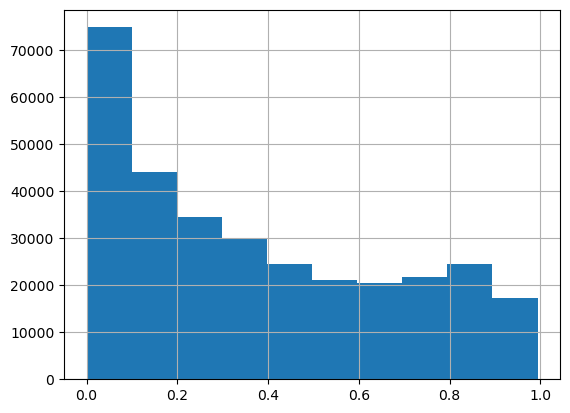

In [108]:
# looking at the hist plot of the final preds
# the distribution differs a fair bit, may need to revisit
sub_df['swing'].hist()